In [97]:
import pandas as pd

In [98]:
df = pd.read_csv("HW2_data/international_matches.csv")
df.tail(10)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


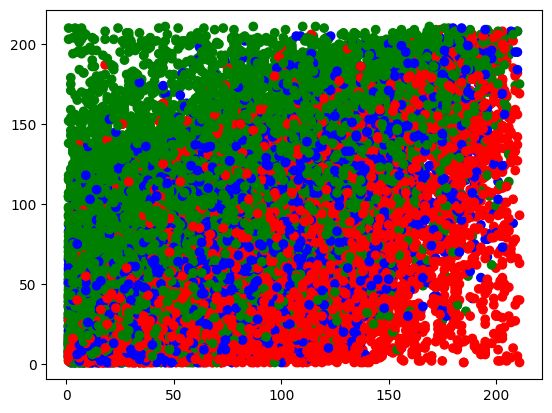

In [99]:
import matplotlib.pyplot as plt

plt.scatter(df['home_team_fifa_rank'], df['away_team_fifa_rank'], c=df['home_team_result'].map({'Lose': 'red', 'Win': 'green', 'Draw': 'blue'}))
plt.show()

In [115]:
import numpy as np
col_ls = ['home_team_fifa_rank', 'home_team_total_fifa_points', 'away_team_fifa_rank', 'away_team_total_fifa_points', 'home_team_result']
df = df[col_ls]

df = df[np.logical_and(df['home_team_total_fifa_points'] > 0, df['away_team_total_fifa_points'] > 0)]
df['home_team_result_one_hot'] = df['home_team_result'].map({'Lose': '0', 'Win': '2', 'Draw': '1'})

train_size = int(len(df) * 75 / 100)
df = df.sample(frac=1)
train = df[:train_size]
test = df[train_size:]


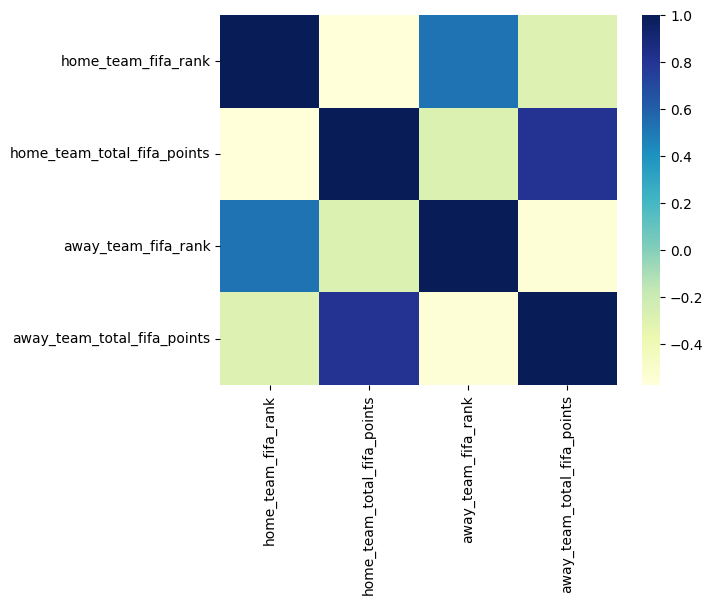

In [116]:
import seaborn as sb

sb.heatmap(df.iloc[:, :4].corr(), cmap='YlGnBu')
plt.show()

In [117]:
from torch.optim import SGD
from tqdm import trange
import torch
import torch.nn as nn

class NNModel(nn.Module):

    def __init__(self, input_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 8),
            nn.ReLU(),
            nn.Linear(8, 20),
            nn.ReLU(),
            nn.Linear(20, output_size)
        )

    def forward(self, input_data):
        return self.layers(input_data)


def learn(nn_model, algo, loss, xs, ys, batch):
    total_loss = 0
    current_result = 0

    for i in range(0, len(ys), batch):
        x = torch.tensor(xs[i:min(len(ys), i + batch)], dtype=torch.float32)
        y = torch.tensor(ys[i:min(len(ys),i + batch)], dtype=torch.float32)
        algo.zero_grad()
        res = nn_model.forward(x)
        current_loss = loss(res, y.type(torch.LongTensor))
        current_loss.backward()

        algo.step()
        current_result += (np.argmax(res.data, axis=1) == y).sum().data
        total_loss += current_loss.data
    return current_result.data / len(ys), total_loss


res: 0.57: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]


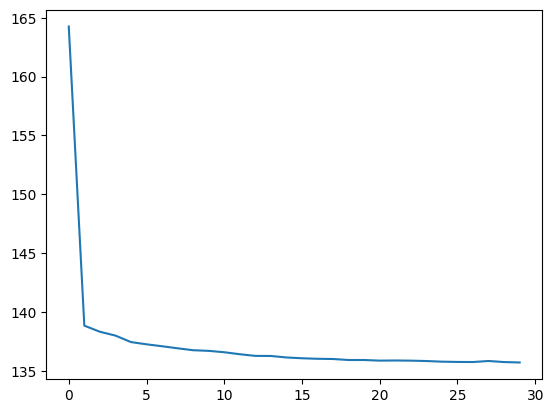

In [118]:

nn_model = NNModel(4, 3)
learning_rate = 0.001
momentum = 0.95
algo = SGD(nn_model.parameters(), lr=learning_rate, momentum=momentum)
loss = nn.CrossEntropyLoss()

train_np = train.to_numpy()
test_np = test.to_numpy()

loss_values = []
results = []
batch = 50
n_epochs = 30
for i in (k:=trange(n_epochs)):
    acc, total_loss = learn(nn_model, algo, loss, train_np[:, :4].astype('float32'), train_np[:, 5].astype('float32'), batch)
    k.set_description("res: %.2f" % acc)
    results.append(acc)
    loss_values.append(total_loss)

plt.plot(range(n_epochs), loss_values)



In [119]:
x = torch.tensor(test_np[:, :4].astype('float32'), dtype=torch.float32)
y = torch.tensor(test_np[:, 5].astype('float32'), dtype=torch.float32)
res = nn_model.forward(x)
current_loss = loss(res, y.type(torch.LongTensor))

print('accuracy: ', (np.argmax(res.data, axis=1) == y).sum().data / len(y), ', loss: ', current_loss.data)

accuracy:  tensor(0.5632) , loss:  tensor(0.9636)


In [124]:
england = torch.tensor([20, 1564.61, 5, 1728.47])
wales = torch.tensor([20, 1564.61, 19, 1569.82])
usa = torch.tensor([20, 1564.61, 16, 1627.48])

print('game with england predication: ', int(np.argmax(nn_model.forward(england).data)))
print('game with wales predication: ', int(np.argmax(nn_model.forward(wales).data)))
print('game with usa predication: ', int(np.argmax(nn_model.forward(usa).data)))

game with england predication:  0
game with wales predication:  0
game with usa predication:  0
